# 範例 : (Kaggle)房價預測
## [教學目標]
以下用房價預測資料, 練習特徵重要性的寫作與觀察 <br />
由於只有樹狀模型有特徵重要性, 故以梯度提升樹為模型作為範例 <br />
## [範例重點]
使用擬合過的模型, 計算特徵重要性 <br />
對照原始特徵, 觀察特徵重要性較高的一半特徵, 搭配梯度提升樹對於測結果的影響<br />
重組重要性最高的特徵作為新特徵, 觀察效果如何 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor

data_dir = './data/'

train_df = pd.read_csv(data_dir + 'train.csv')
train_label = np.log1p(train_df.SalePrice)
train_df = train_df.drop(['Id','SalePrice'], axis = 1)
train_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [2]:
import warnings
warnings.filterwarnings('ignore')
for col in train_df.columns:
    train_df[col] = train_df[col].fillna(-1)
    if train_df[col].dtype == 'object':
        train_df[col] = LabelEncoder().fit_transform(list(train_df[col].values))
    train_df[col] = MinMaxScaler().fit_transform(train_df[col].values.reshape(-1,1))

train_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.235294,0.75,0.210191,0.033420,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.50,1.0,0.8
1,0.000000,0.75,0.257962,0.038795,1.0,0.0,1.0,1.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.25,1.0,0.8
2,0.235294,0.75,0.219745,0.046507,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.727273,0.50,1.0,0.8
3,0.294118,0.75,0.194268,0.038561,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.00,1.0,0.0
4,0.235294,0.75,0.270701,0.060576,1.0,0.0,0.0,1.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.50,1.0,0.8


In [3]:
GBR = GradientBoostingRegressor()
GBR.fit(train_df,train_label)

feats = pd.Series(data = GBR.feature_importances_, index = train_df.columns).sort_values(ascending = False)
feats

OverallQual      0.459970
GrLivArea        0.173757
TotalBsmtSF      0.052678
YearBuilt        0.045011
GarageCars       0.044696
BsmtFinSF1       0.027498
YearRemodAdd     0.022085
LotArea          0.020247
OverallCond      0.016849
1stFlrSF         0.015790
CentralAir       0.014168
GarageArea       0.013226
MSZoning         0.010831
Fireplaces       0.009739
KitchenQual      0.007983
GarageYrBlt      0.006515
ExterQual        0.006373
FireplaceQu      0.006183
2ndFlrSF         0.005520
FullBath         0.005342
SaleCondition    0.003248
GarageType       0.002512
Neighborhood     0.002352
Functional       0.002073
BsmtQual         0.002028
BsmtFullBath     0.001947
OpenPorchSF      0.001759
BsmtExposure     0.001416
ScreenPorch      0.001402
WoodDeckSF       0.001334
                   ...   
LandContour      0.000333
LotShape         0.000310
BsmtFinSF2       0.000295
GarageFinish     0.000285
BedroomAbvGr     0.000244
Exterior2nd      0.000243
MoSold           0.000193
ExterCond   

In [4]:
import copy 
train_x = copy.deepcopy(train_df)
cross_val_score(GBR,train_x,train_label,cv=5).mean()

0.8945710725590331

In [5]:
high_features = feats[:int(len(feats)/2)].index
train_x = copy.deepcopy(train_df[high_features])
cross_val_score(GBR,train_x,train_label,cv=5).mean()

0.8999131393809245

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x = train_df['GrLivArea'], y = train_label, fit_reg = False)
plt.show()

<Figure size 640x480 with 1 Axes>

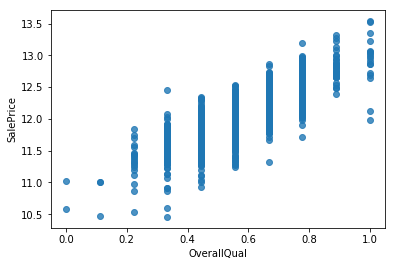

In [7]:
sns.regplot(x = train_df['OverallQual'], y = train_label, fit_reg = False)
plt.show()

In [8]:
train_df['Add_char'] = (train_df['OverallQual'] + train_df['GrLivArea'])/2
train_df['Multi_char'] = (train_df['OverallQual'] * train_df['GrLivArea'])
train_df['GO_div1p'] = (train_df['GrLivArea'] / (train_df['OverallQual']+1)) * 2
train_df['OG_div1p'] = (train_df['OverallQual'] / (train_df['GrLivArea']+1)) * 2
train_x = MinMaxScaler().fit_transform(train_df)
cross_val_score(GBR,train_x,train_label,cv=5).mean()

0.8946444348519835

# 先用梯度提升機對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題
## 作業1
將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?<br />
## 作業2
將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力? <br />

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

df = pd.read_csv(data_dir + 'titanic_train.csv')
train_label = df.Survived
df = df.drop(['PassengerId','Survived'], axis = 1)

df.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
import warnings
warnings.filterwarnings('ignore')
for col in df.columns:
    df[col] = df[col].fillna(-1)
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(list(df[col].values))
    df[col] = MinMaxScaler().fit_transform(df[col].values.reshape(-1,1))
df.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [19]:
GBC = GradientBoostingClassifier()
GBC.fit(df,train_label)
feats = pd.Series(GBC.feature_importances_, index = df.columns).sort_values(ascending = False)
feats

Sex         0.444227
Pclass      0.111905
Ticket      0.095819
Fare        0.088465
Name        0.082000
Age         0.074960
Cabin       0.071116
Embarked    0.012220
Parch       0.011530
SibSp       0.007758
dtype: float64

## 先用梯度提升機對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題
# 作業1
將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

In [20]:
#Original features + GBC
train_x = copy.deepcopy(df)
cross_val_score(GBC,train_x,train_label,cv=5).mean()

0.8215972695810002

In [21]:
high_feats = feats[0:int(len(feats)/2)].index
train_x = copy.deepcopy(df[high_feats])
cross_val_score(GBC,train_x,train_label,cv=5).mean()

0.8125895324717789

# 作業2
將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?

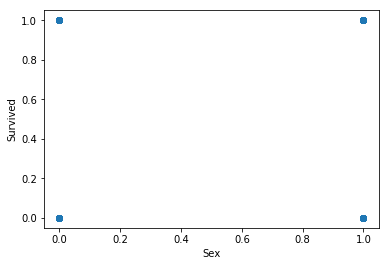

In [23]:
sns.regplot(x=df.Sex,y=train_label,fit_reg = False)
plt.show()

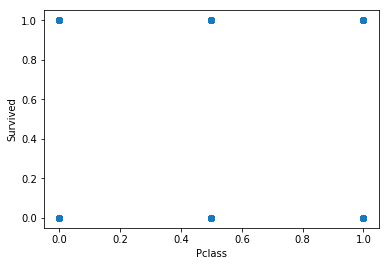

In [24]:
sns.regplot(x=df.Pclass,y=train_label,fit_reg = False)
plt.show()

In [28]:
df['Multi_SP'] = df.Pclass * df.Sex
df['Add_SP']  = df.Pclass + df.Sex

train_x = MinMaxScaler().fit_transform(df)
cross_val_score(GBC,train_x,train_label,cv=5).mean()

0.8271397094886954